**url**

https://news.northropgrumman.com/news/releases?page=1

In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd,requests,bs4,re,time,io,pytesseract,easyocr,random
from pdfminer.high_level import extract_text
from PIL import Image
from pathlib import Path
from pdf2image import convert_from_path
from selenium.webdriver.common.by import By
from goose3 import Goose
from datetime import datetime
from bs4 import BeautifulSoup
from selenium import webdriver

reader = easyocr.Reader(['en'])

import warnings
warnings.filterwarnings("ignore")

%autosave 1

D:\Anaconda\envs\gpu_16march2022\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Autosaving every 1 seconds


In [2]:
SITE_NAME='Northropgrumman'

DOMAIN = "https://news.northropgrumman.com"

SITE_LINK="https://news.northropgrumman.com/news/releases?page=1"

In [3]:
def parse_webpage_bs(search_url):
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0"}
    try:
        site_request = requests.get(search_url, headers=headers, timeout=10)
    except requests.exceptions.RequestException as e:
        print(e)
        site_request = None
    if site_request != None and site_request.status_code==200:
        site_soup = bs4.BeautifulSoup(site_request.content, "lxml")
    else:
        site_soup = None
    return site_soup

def remove_esc_chars(text):
    return text.replace("\n", " ").replace("\t", " ").replace("\r", " ")

def get_text(link):
    g = Goose()
    article_extract = g.extract(url=link)
    article = remove_esc_chars(article_extract.cleaned_text)
    meta_data = remove_esc_chars(article_extract.meta_description)
    whole_data = meta_data+article
    text = whole_data.strip()
    
    if len(text) < 10:
        try:
            response = requests.get(link)
            text = remove_esc_chars(extract_text(io.BytesIO(response.content)))

            if len(text) < 10:
                texts = ""
                r = requests.get(link)
                filename = Path('temp.pdf')
                filename.write_bytes(r.content)

                pages = convert_from_path('temp.pdf', 500)
                for x in pages:
                    x.save("temp.jpg")
                    output = reader.readtext("temp.jpg")
                    for o in output:
                        texts += o[1]

                text = remove_esc_chars(texts)
        except:
            text = ""
    
    return text

In [4]:
article_list = []
pagination = 1
last_page = 752

last_page = 5

while pagination <= last_page:
    url = f"https://news.northropgrumman.com/news/releases?page={pagination}"
    soup = parse_webpage_bs(url)
    
    if soup != None:
        elements = soup.findAll('article',{'class' :'index-item clearfix'})
        for element in elements:
            
            #title,published_date,link,thumbnail,author
            title = element.find('div',{'class' :'col-md-7'}).find("a").text.strip()
            published_date = element.find('div',{'class' :'index-item-info'}).text.strip()
            link = DOMAIN + element.find('div',{'class' :'col-md-7'}).find("a")['href']
            author = SITE_NAME
            try:
                thumbnail =  element.find('div',{'class' :'col-md-5'}).find("img")['src']

                if len(re.findall("http",thumbnail)) < 1:
                    thumbnail = DOMAIN + element.find('div',{'class' :'col-md-5'}).find("img")['src']
            except:
                thumbnail = "https://news.northropgrumman.com/media/themes/57616dda2cfac26dc9d3c826/images/ng_logo_default.jpg"
            
            #text 
            text = get_text(link)
            
            article = (published_date.strip(),title.strip(),text.strip(),link.strip(),thumbnail.strip(),author.strip())
            article_list.append(article)
            print(published_date,title)
            
    pagination += 1

Jun 01, 2022 Northrop Grumman to Participate in the Jefferies Virtual ESG Summit
May 25, 2022 Northrop Grumman Australia Announces Tech Showcase Winners
May 23, 2022 US Navy Deploys MQ-8C Fire Scout to Indo-Pacific
May 17, 2022 Northrop Grumman Increases Quarterly Dividend 10 Percent to $1.73
May 16, 2022 Northrop Grumman to Participate in Bernstein’s 38th Annual Strategic Decisions Conference
May 12, 2022 Northrop Grumman Corporation Commences Registered Exchange Offer for Notes Issued in Connection with Prior Private Exchange Offer
May 10, 2022 Northrop Grumman Names Kenny Robinson as Chief Diversity Officer
May 10, 2022 Northrop Grumman to Webcast Annual Shareholders Meeting; Announces Specifics for In-Person Meeting Attendance
May 09, 2022 Northrop Grumman’s FAAD C2 Plays Integral Role Testing JADC2 Messaging Standard
May 04, 2022 Northrop Grumman Australia Team Brings Together Space Capabilities for JP9102
May 03, 2022 Northrop Grumman Advances F-16 Electronic Warfare Suite Integr

In [5]:
temp_df = pd.DataFrame(article_list,columns=['date','title','article','url','thumbnail','author'])
temp_df.head()

,date,title,article,url,thumbnail,author
0,"Jun 01, 2022",Northrop Grumman to Participate in the Jefferi...,"FALLS CHURCH, Va. – June 1, 2022 – Northrop Gr...",https://news.northropgrumman.com/news/releases...,https://s3.amazonaws.com/cms.ipressroom.com/29...,Northropgrumman
1,"May 25, 2022",Northrop Grumman Australia Announces Tech Show...,"SYDNEY – May 26, 2022 – Northrop Grumman Austr...",https://news.northropgrumman.com/news/releases...,https://news.northropgrumman.com/media/themes/...,Northropgrumman
2,"May 23, 2022",US Navy Deploys MQ-8C Fire Scout to Indo-Pacific,"SAN DIEGO – May 23, 2022 – Northrop Grumman Co...",https://news.northropgrumman.com/news/releases...,https://s3.amazonaws.com/cms.ipressroom.com/29...,Northropgrumman
3,"May 17, 2022",Northrop Grumman Increases Quarterly Dividend ...,"FALLS CHURCH, Va. – May 17, 2022 – The board o...",https://news.northropgrumman.com/news/releases...,https://s3.amazonaws.com/cms.ipressroom.com/29...,Northropgrumman
4,"May 16, 2022",Northrop Grumman to Participate in Bernstein’s...,"FALLS CHURCH, Va. – May 16, 2022 – Northrop Gr...",https://news.northropgrumman.com/news/releases...,https://s3.amazonaws.com/cms.ipressroom.com/29...,Northropgrumman


Mar 01, 2022 Northrop Grumman to Participate in J.P. Morgan Industrials Conference

Northropgrumman https://news.northropgrumman.com/news/releases/northrop-grumman-to-participate-in-j-p-morgan-industrials-conference


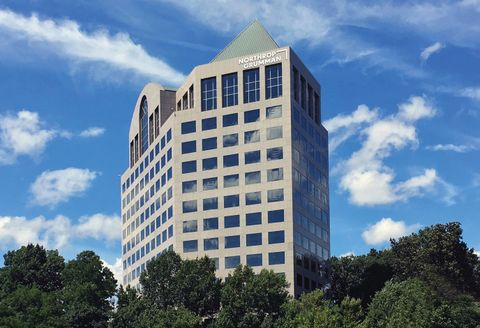


FALLS CHURCH, Va. – March 1, 2022 – Northrop Grumman Corporation (NYSE: NOC) will participate in the 2022 J.P. Morgan Industrials Conference on Tuesday, March 15. Dave Keffer, corporate vice president and chief financial officer, will present beginning...FALLS CHURCH, Va. – March 1, 2022 – Northrop Grumman Corporation (NYSE: NOC) will participate in the 2022 J.P. Morgan Industrials Conference on Tuesday, March 15. Dave Keffer, corporate vice president and chief financial officer, will present beginning at 2:10 p.m. Eastern time. The presentation will be webcast live at http://investor.northropgrumman.com.  Northrop Grumman is a technology company, focused on global security and human discovery. Our pioneering solutions equip our customers with capabilities they need to connect, advance and protect the U.S. and its allies. Driven by a shared purpose to solve our customers’ toughest problems, our 90,000 employees define possible every day.  Note: Statements to be made at the conference,

In [6]:
def see_data(iloc_no=random.randint(0,len(temp_df))-1):
    print(temp_df.iloc[iloc_no]['date'],temp_df.iloc[iloc_no]['title'])
    print(f"\n{temp_df.iloc[iloc_no]['author']} {temp_df.iloc[iloc_no]['url']}")
    display(Image.open(io.BytesIO(requests.get(temp_df.iloc[iloc_no]['thumbnail']).content)))
    print(f"\n{temp_df.iloc[iloc_no]['article']}")

see_data()

In [7]:
#to csv
temp_df.to_csv(f'{SITE_NAME} news.csv',index = False)

#to json
temp_df.to_json(f'{SITE_NAME} news.json')

In [8]:
#to get rid of unwanteed trash created by the model use 
def remove_trash():
    try:
        os.remove("temp.jpg")
        os.remove("temp.pdf")
        print("Trash removed successfully")
    except:
        print("No trash found")

remove_trash()

No trash found
